Device utilisé: cuda
Dataset: 2975 images trouvées
=== DÉBUT ENTRAÎNEMENT VAE ===
Nombre de paramètres: 39136707
Epoch 0/20, Loss: 85915.01


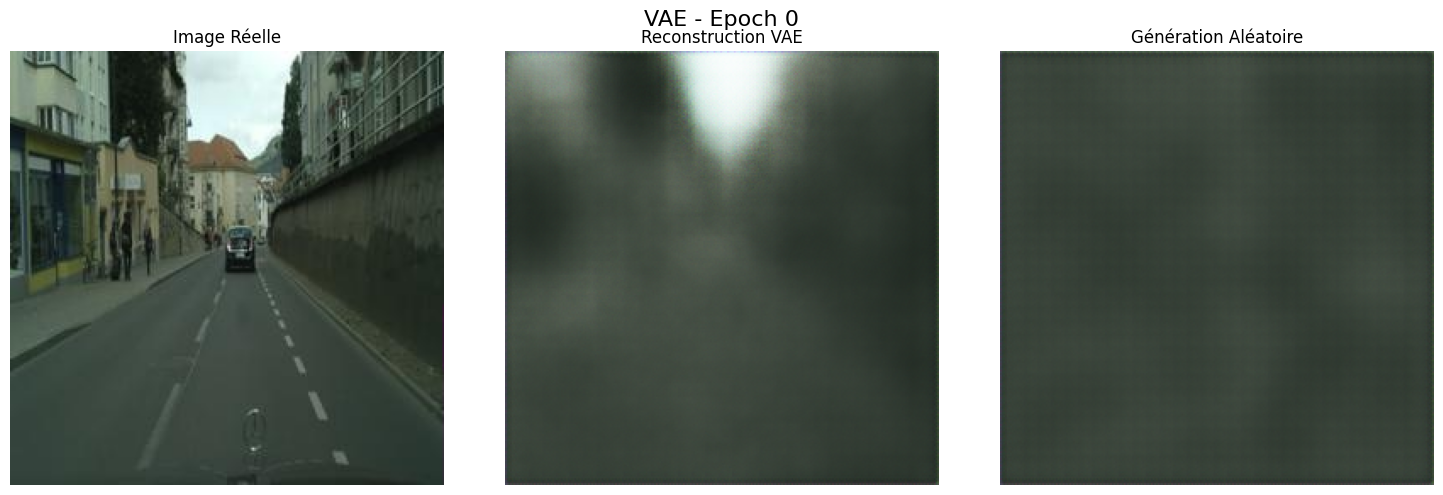

Epoch 2/20, Loss: 49103.18


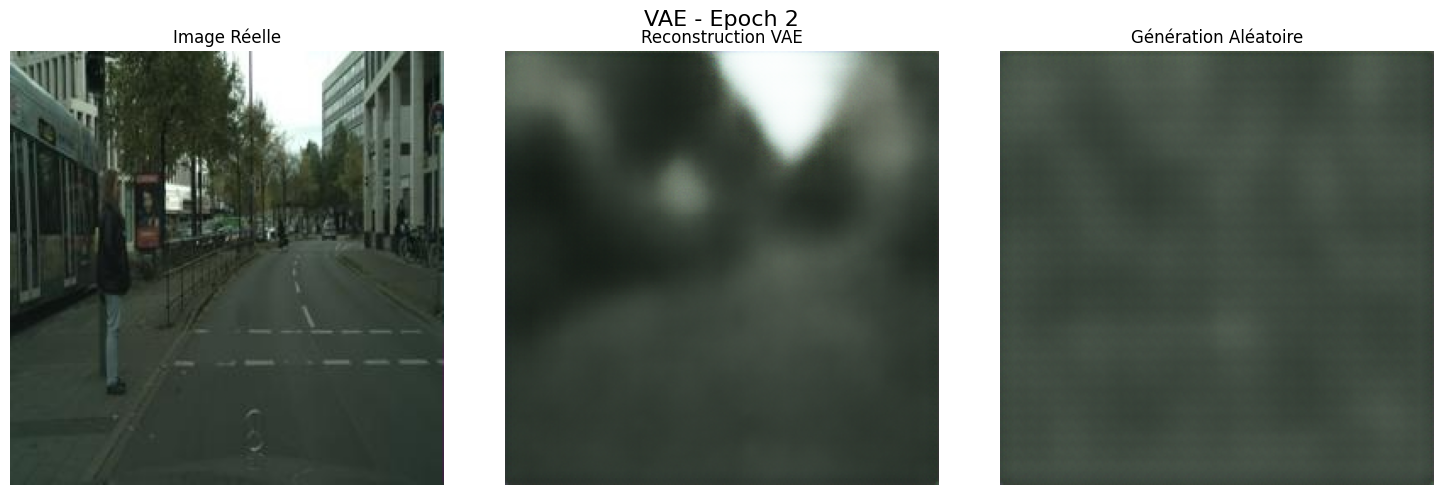

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os

class CityscapesVAE(nn.Module):
    def __init__(self, latent_dim=128, img_size=256):
        super(CityscapesVAE, self).__init__()
        self.latent_dim = latent_dim
        self.img_size = img_size
        
        # === ENCODEUR (Image -> mu, sigma) ===
        self.encoder = nn.Sequential(
            # 256x256x3 -> 128x128x64
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            
            # 128x128x64 -> 64x64x128
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # 64x64x128 -> 32x32x256
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            # 32x32x256 -> 16x16x512
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            # 16x16x512 -> 8x8x512
            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            # Flatten
            nn.Flatten()
        )
        
        # Dimensions après encodage
        self.encoder_output_dim = 8 * 8 * 512  # 32768
        
        # Couches pour mu et sigma (dimension latente plus grande)
        self.fc_mu = nn.Linear(self.encoder_output_dim, latent_dim)
        self.fc_sigma = nn.Linear(self.encoder_output_dim, latent_dim)
        
        # === DÉCODEUR (z -> Image) ===
        self.fc_decode = nn.Linear(latent_dim, self.encoder_output_dim)
        
        self.decoder = nn.Sequential(
            # Reshape vers 8x8x512
            nn.Unflatten(1, (512, 8, 8)),
            
            # 8x8x512 -> 16x16x512
            nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            # 16x16x512 -> 32x32x256
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            # 32x32x256 -> 64x64x128
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # 64x64x128 -> 128x128x64
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # 128x128x64 -> 256x256x32 (couche intermédiaire)
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # Couche finale pour affiner les détails
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()  # Output entre 0 et 1
        )
    
    def encode(self, x):
        """1-2: Données d'entrée -> zone latente -> mu & sigma"""
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        log_sigma = self.fc_sigma(encoded)  # log pour stabilité numérique
        return mu, log_sigma
    
    def reparameterize(self, mu, log_sigma):
        """4: Échantillonnage avec reparameterization trick"""
        std = torch.exp(0.5 * log_sigma)
        eps = torch.randn_like(std)  # Bruit gaussien
        z = mu + eps * std  # z ~ N(mu, sigma²)
        return z
    
    def decode(self, z):
        """5: Zone latente -> Image générée"""
        decoded = self.fc_decode(z)
        reconstructed = self.decoder(decoded)
        return reconstructed
    
    def forward(self, x):
        """Pipeline complet du VAE"""
        # 1-2-3: Encoder
        mu, log_sigma = self.encode(x)
        
        # 4: Échantillonnage
        z = self.reparameterize(mu, log_sigma)
        
        # 5: Decoder
        reconstructed = self.decode(z)
        
        return reconstructed, mu, log_sigma

class CityscapesDataset(Dataset):
    def __init__(self, data_dir, img_size=256):
        self.img_size = img_size
        
        # Trouver toutes les images
        self.image_paths = glob.glob(os.path.join(data_dir, "**", "*.png"), recursive=True)
        self.image_paths.extend(glob.glob(os.path.join(data_dir, "**", "*.jpg"), recursive=True))
        
        print(f"Dataset: {len(self.image_paths)} images trouvées")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        try:
            # Charger l'image
            img = Image.open(img_path).convert('RGB')
            
            # Prendre la moitié gauche (comme dans le GAN)
            width, height = img.size
            left_half = img.crop((0, 0, width//2, height))
            left_half = left_half.resize((self.img_size, self.img_size), Image.LANCZOS)
            
            # Convertir en tensor [0,1]
            img_array = np.array(left_half, dtype=np.float32) / 255.0
            img_tensor = torch.from_numpy(img_array).permute(2, 0, 1)  # HWC -> CHW
            
            return img_tensor
            
        except Exception as e:
            print(f"Erreur chargement {img_path}: {e}")
            # Retourner une image noire en cas d'erreur
            return torch.zeros(3, self.img_size, self.img_size)

def vae_loss(reconstructed, original, mu, log_sigma, beta=1.0):
    """6: Loss VAE améliorée = Reconstruction Loss + β-KL Divergence + Perceptual Loss"""
    
    # Loss de reconstruction (combinaison MSE + L1 pour plus de netteté)
    mse_loss = F.mse_loss(reconstructed, original, reduction='sum')
    l1_loss = F.l1_loss(reconstructed, original, reduction='sum')
    reconstruction_loss = mse_loss + 0.5 * l1_loss
    
    # KL Divergence avec coefficient beta (β-VAE)
    kl_divergence = -0.5 * torch.sum(1 + log_sigma - mu.pow(2) - log_sigma.exp())
    
    # Loss perceptuelle simple (différence de gradients pour capturer les détails)
    def gradient_loss(img1, img2):
        # Gradients horizontaux et verticaux
        grad_x1 = img1[:, :, :, 1:] - img1[:, :, :, :-1]
        grad_y1 = img1[:, :, 1:, :] - img1[:, :, :-1, :]
        grad_x2 = img2[:, :, :, 1:] - img2[:, :, :, :-1]
        grad_y2 = img2[:, :, 1:, :] - img2[:, :, :-1, :]
        
        return F.l1_loss(grad_x1, grad_x2) + F.l1_loss(grad_y1, grad_y2)
    
    perceptual_loss = gradient_loss(reconstructed, original)
    
    return reconstruction_loss + beta * kl_divergence + 10.0 * perceptual_loss

def train_vae(data_dir, epochs=1000, batch_size=16, learning_rate=1e-3):
    """Entraînement principal du VAE"""
    
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device utilisé: {device}")
    
    # Dataset et DataLoader
    dataset = CityscapesDataset(data_dir)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    # Modèle
    vae = CityscapesVAE(latent_dim=256).to(device)  # Dimension latente plus grande
    
    # Optimiseur
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
    
    print("=== DÉBUT ENTRAÎNEMENT VAE ===")
    print(f"Nombre de paramètres: {sum(p.numel() for p in vae.parameters())}")
    
    # Boucle d'entraînement
    for epoch in range(epochs):
        vae.train()
        total_loss = 0
        
        for batch_idx, data in enumerate(dataloader):
            data = data.to(device)
            
            # Forward pass
            reconstructed, mu, log_sigma = vae(data)
            
            # 6: Calcul de la loss et backpropagation avec β-VAE
            beta = min(1.0, epoch / 500)  # β progressif : 0 -> 1 sur 500 époques
            loss = vae_loss(reconstructed, data, mu, log_sigma, beta)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        
        # Affichage et test tous les 2 époques
        if epoch % 2 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.2f}")
            
            # Générer et afficher une image de test avec référence
            test_images = generate_test_image(vae, device, epoch, dataloader)
    
    print("=== ENTRAÎNEMENT TERMINÉ ===")
    
    # Image finale
    final_images = generate_test_image(vae, device, epochs, dataloader, title="RÉSULTATS FINAUX")
    
    # Sauvegarder le modèle
    torch.save(vae.state_dict(), 'cityscapes_vae.pth')
    print("Modèle sauvegardé: cityscapes_vae.pth")
    
    return vae

def generate_test_image(vae, device, epoch, dataloader, title=None):
    """Génère et affiche une image de test à côté d'une image de référence"""
    vae.eval()
    
    with torch.no_grad():
        # Prendre une image réelle du dataset comme référence
        real_batch = next(iter(dataloader))
        real_image = real_batch[0].to(device).unsqueeze(0)  # Premier échantillon
        
        # Reconstruire cette image via le VAE
        reconstructed, mu, log_sigma = vae(real_image)
        
        # Générer aussi une image complètement nouvelle
        z_random = torch.randn(1, vae.latent_dim).to(device)
        generated_new = vae.decode(z_random)
        
        # Convertir pour affichage
        real_img = real_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
        reconstructed_img = reconstructed.cpu().squeeze(0).permute(1, 2, 0).numpy()
        generated_img = generated_new.cpu().squeeze(0).permute(1, 2, 0).numpy()
        
        # Clipper les valeurs
        real_img = np.clip(real_img, 0, 1)
        reconstructed_img = np.clip(reconstructed_img, 0, 1)
        generated_img = np.clip(generated_img, 0, 1)
        
        # Afficher côte à côte
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(real_img)
        axes[0].set_title("Image Réelle")
        axes[0].axis('off')
        
        axes[1].imshow(reconstructed_img)
        axes[1].set_title("Reconstruction VAE")
        axes[1].axis('off')
        
        axes[2].imshow(generated_img)
        axes[2].set_title("Génération Aléatoire")
        axes[2].axis('off')
        
        if title:
            fig.suptitle(f"{title}", fontsize=16)
        else:
            fig.suptitle(f"VAE - Epoch {epoch}", fontsize=16)
        
        plt.tight_layout()
        plt.show()
        
        return reconstructed_img, generated_img

def main():
    """Pipeline principal"""
    data_dir = "/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/"
    
    # Entraîner le VAE
    vae = train_vae(
        data_dir=data_dir,
        epochs=20,  # Plus d'époques
        batch_size=6,  # Batch plus petit pour plus de stabilité
        learning_rate=5e-5  # Learning rate plus petit pour plus de finesse
    )
    
    print("VAE entraîné avec succès !")

if __name__ == "__main__":
    main()